### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [3]:
#importing tools
import numpy as np
import scipy
import matplotlib.pyplot as plt

### Part 1

In [4]:
#Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. 
#It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), 
#the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. 
#Plot this data with the uncertainties.


#Reading in the data
data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw5_data_1.npy')
print(data)

[[ 0.46954762  8.83485016  1.        ]
 [ 1.87898004 10.90082649  1.        ]
 [ 2.01075462 10.46566244  1.        ]
 [ 2.02183974  8.46375631  1.        ]
 [ 3.91877923 11.48825219  1.        ]
 [ 6.02254716 11.89588918  1.        ]
 [ 6.41474963 11.17877957  1.        ]
 [ 7.10360582  9.82007516  1.        ]
 [ 8.71292997  8.92924738  1.        ]
 [ 9.39405108 11.05445173  1.        ]
 [ 9.60984079  9.59682305  1.        ]
 [ 9.71012758 11.22244507  1.        ]
 [10.20448107 10.20827498  1.        ]
 [11.03751412 10.97663904  1.        ]
 [11.82744259 10.3563664   1.        ]
 [11.8727719  10.70657317  1.        ]
 [12.01965612 10.01050002  1.        ]
 [12.89262977 11.78587049  1.        ]
 [13.17978624 10.12691209  1.        ]
 [13.81829513 10.40198936  1.        ]
 [14.33532874 11.8831507   1.        ]
 [15.89695836  8.65224094  1.        ]
 [16.13095179  8.729515    1.        ]
 [18.3191362  10.96939671  1.        ]
 [19.65823617  8.82687659  1.        ]
 [20.88767561 11.94362119

Text(0.5, 1.0, 'Flux Over Time with Homoscedastic Error')

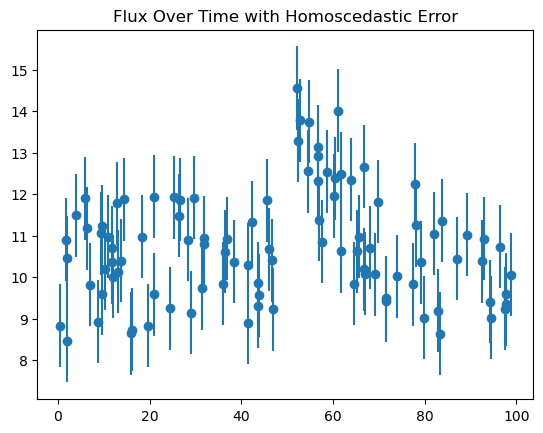

In [5]:
#plotting data with uncertainties

#setting columns as variables
t = data[:,0]           #time
flux = data[:,1]        #flux
sigma_fl = data[:,2]    #flux uncertainty


#plotting
plt.scatter(t,flux)
plt.errorbar(x=t,y=flux,yerr=sigma_fl, fmt='None')
plt.title('Flux Over Time with Homoscedastic Error')

### Part 2

One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$
$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.


In [6]:
#Code this burst model, and code a likelihood function for this data with the burst model. 
#*Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

#defining model as a function
def exp_burst_fit(theta, x):
    b,A,t0,lnalpha = theta
    y=[]
    for t in x:
        if t<t0:
            yy = b
            y.append(yy)
        if t>=t0:
            yy = b + A*np.exp(-np.exp(lnalpha)*(t-t0))
            y.append(yy)
    return y


Text(0.5, 1.0, 'Flux Over Time with Homoscedastic Error')

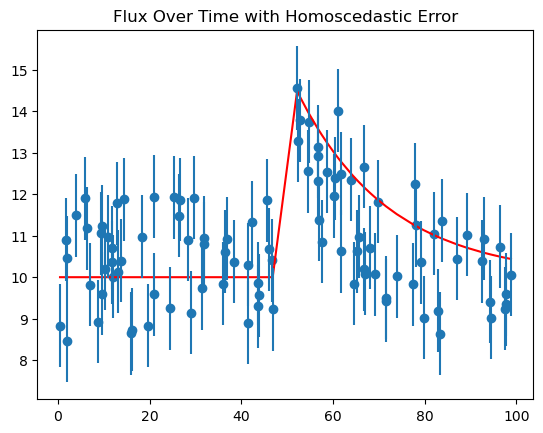

In [7]:
#test plotting my exp_burst_fit
plt.scatter(t,flux)
plt.plot(t,exp_burst_fit(theta=[10,5,50,-3],x=t), color='red')
plt.errorbar(x=t,y=flux,yerr=sigma_fl, fmt='None')
plt.title('Flux Over Time with Homoscedastic Error')

In [8]:
# compute the data log-likelihood given a model
def logL(theta, data=data, model=exp_burst_fit):
    #"""Gaussian log-likelihood of the model at theta"""
    #separating data into columns
    x = data[:,0]
    y = data[:,1]
    sigma_y = data[:,2]
    #fitting model
    y_fit = exp_burst_fit(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

### Part 3

In [9]:
#Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain 
# of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. 
#For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

#Making Priors
b_prior = scipy.stats.uniform(0,50)         #low bound 0, width 50 = high bound 50
A_prior = scipy.stats.uniform(0,100)        #low bound 0, width 100 = high bound 100
t0_prior = scipy.stats.uniform(0,100)       #low bound 0, width 100 = high bound 100
lnalpha_prior = scipy.stats.uniform(-5,10)    #low bound -5, width 10 = high bound 5

#much of the framework I am using here is drawn from Lecture 11

Need the following cells for mpi4py and acor

In [13]:
!pip3 install git+https://github.com/jellis18/PTMCMCSampler@master

  Cloning https://github.com/jellis18/PTMCMCSampler (to revision master) to /tmp/pip-req-build-q5dz8f56
  Running command git clone --filter=blob:none --quiet https://github.com/jellis18/PTMCMCSampler /tmp/pip-req-build-q5dz8f56
  Resolved https://github.com/jellis18/PTMCMCSampler to commit 98110732aa5b031daab254f3abefc4b80fda4487
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [14]:
!pip3 install git+https://github.com/dfm/acor@master

  Cloning https://github.com/dfm/acor (to revision master) to /tmp/pip-req-build-7o33djcc
  Running command git clone --filter=blob:none --quiet https://github.com/dfm/acor /tmp/pip-req-build-7o33djcc
  Running command git checkout -b master --track origin/master
  Switched to a new branch 'master'
  Branch 'master' set up to track remote branch 'master' from 'origin'.
  Resolved https://github.com/dfm/acor to commit b55eb8efa7df6c73b6f3f0c9b64fa1c801e8f821
  Preparing metadata (setup.py) ... done


Now to do the MCMC chain using PTMCMC

In [138]:
#starting mcmc chain

#using PTMCMC
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc #importing PTMCMC

#building parts for MCMC:
# dimension of parameter space
ndim = 4 #dimensions are b, A, t0, alpha
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * (0.01)**2)    #array of 4 dimensions filled with ones, made diagonal

#defining function of priors to be used in findng the posterior
def logPrior(theta):
    b, A, t0, lnalpha = theta
    #getting pdfs of the priors
    b_pdf = b_prior.logpdf(b)
    A_pdf = A_prior.logpdf(A)
    t0_pdf = t0_prior.logpdf(t0)
    lnalpha_pdf = lnalpha_prior.logpdf(lnalpha)
    #combinging prior pdfs together
    combo_prior_pdf = b_pdf + A_pdf + t0_pdf + lnalpha_pdf
    #taking ln of combined prior
    #print(combo_prior_pdf)
    #log_prior = np.log(combo_prior_pdf)
    return combo_prior_pdf #log_prior

# intialize sampler for posterior
sampler = ptmcmc(ndim, logL, logPrior, cov,    #number of dimensions, log likelihood, log priors, initial covariance matrix
                 outDir='./my_ptmcmc_chain_hw5', resume=False)


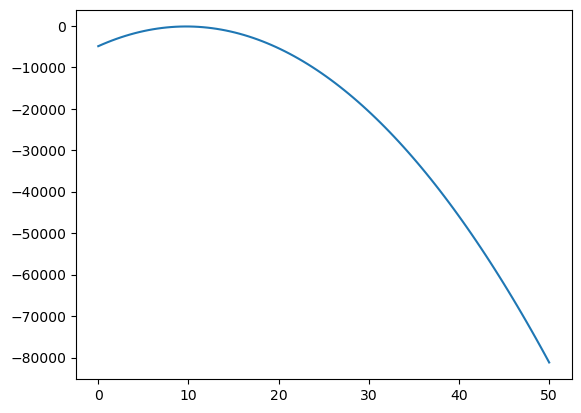

In [141]:
#print(t)
plt.plot(np.linspace(0,50,100),logL([np.linspace(0,50,100),5,50,-3])+logPrior([np.linspace(0,50,100),5,50,-3]))

In [233]:
# now to run the sampler for N steps
N = int(2e5) #200000 steps
x0 = np.array([10.0, 5.0, 50.0, -3.0]) #array of initial guesses for b, A, t0, alpha

#sampling!
sampler.sample(x0, N, 
               SCAMweight=30, #Weight of SCAM jumps in overall jump cycle; SCAM=Single COmponent Adaptive
               AMweight=15,   #Weight of AM jumps in overall jump cycle  ; AM=Adaptive Jump
               DEweight=50    #Weight of DE jumps in overall jump cycle  ; DE=Differential Evolution Jump
               )                #Thank you NANOGrav PTMCMC Github or having clean and informative code <3

Finished 0.00 percent in 0.002252 s Acceptance rate = 0

Finished 5.00 percent in 41.742785 s Acceptance rate = 0.617456Adding DE jump with weight 50
Finished 100.00 percent in 820.862466 s Acceptance rate = 0.441665
Run Complete


### Part 4

In [234]:
#defining my PTMCMC chain
chain = np.loadtxt('./my_ptmcmc_chain_hw5/chain_1.txt')

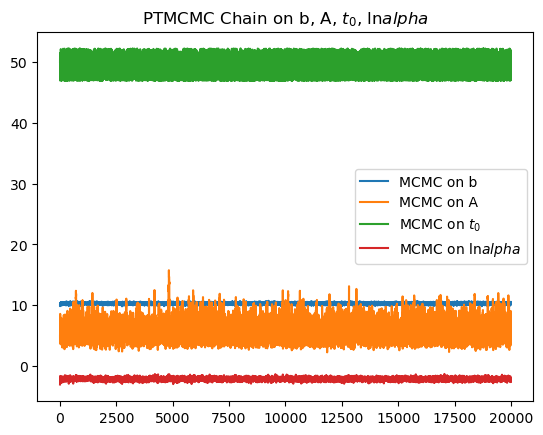

In [236]:
#plot unburned chain
plt.plot(chain[:,:4])
plt.title('PTMCMC Chain on b, A, $t_0$, ln$alpha$')
plt.legend(['MCMC on b', 'MCMC on A', 'MCMC on $t_0$', 'MCMC on ln$alpha$'])

In [237]:
#Checking for proper burn-in

#defining burn to use in burn-in
burn = 400

In [238]:
import acor #importing acor

#defining autocorrelation length
autcor_b = acor.acor(chain[burn:,0])[0]
autcor_A = acor.acor(chain[burn:,1])[0] 
autcor_t0 = acor.acor(chain[burn:,2])[0] 
autcor_alpha = acor.acor(chain[burn:,3])[0] 

In [239]:
print(autcor_b, autcor_A, autcor_t0, autcor_alpha)

3.4582283743439324 6.977885061174182 4.32586885958462 4.636714793964339


[[10.36913919  7.15811936 47.23006055 -2.15438478]
 [10.30807647  5.83055189 49.49313089 -1.90046377]
 [10.19362209  3.70574706 51.98281671 -2.18565249]
 ...
 [10.13111392  5.3643331  50.13538621 -2.16469923]
 [10.32320238  7.68926544 48.01217978 -1.92727824]
 [10.23680702  7.59540008 47.44562831 -2.12693746]]
[10.36913919 10.0331472  10.30807647 ... 10.25980429 10.23680702
 10.27464149]


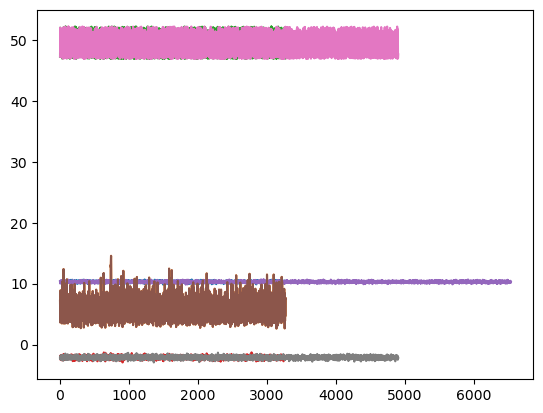

In [240]:
#burning in the chain
burn_chain = chain[burn::,:4]

#thinning whole mcmc by most conservative acor
thin_chain = burn_chain[::int(autcor_A)]
print(thin_chain)

#Thinning chains with their associated autocorrelation lengths
thin_chain_b = burn_chain[::int(autcor_b),0]
thin_chain_A = burn_chain[::int(autcor_A),1]
thin_chain_t0 = burn_chain[::int(autcor_t0),2]
thin_chain_alpha = burn_chain[::int(autcor_alpha),3]
print(thin_chain_b)

#plotting thinned and burned chain
plt.plot(thin_chain, label='Thinned and Burned-in MCMC Chain with Most Conservative autcor')

plt.plot(thin_chain_b, label='Thinned and Burned-in MCMC Chain for b')
plt.plot(thin_chain_A, label='Thinned and Burned-in MCMC Chain for A')
plt.plot(thin_chain_t0, label='Thinned and Burned-in MCMC Chain for $t_0$')
plt.plot(thin_chain_alpha, label='Thinned and Burned-in MCMC Chain for ln$alpha$')

In [241]:
print(len(thin_chain))

print(thin_chain)

3267
[[10.36913919  7.15811936 47.23006055 -2.15438478]
 [10.30807647  5.83055189 49.49313089 -1.90046377]
 [10.19362209  3.70574706 51.98281671 -2.18565249]
 ...
 [10.13111392  5.3643331  50.13538621 -2.16469923]
 [10.32320238  7.68926544 48.01217978 -1.92727824]
 [10.23680702  7.59540008 47.44562831 -2.12693746]]


### Part 5

In [29]:
#Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.
import corner

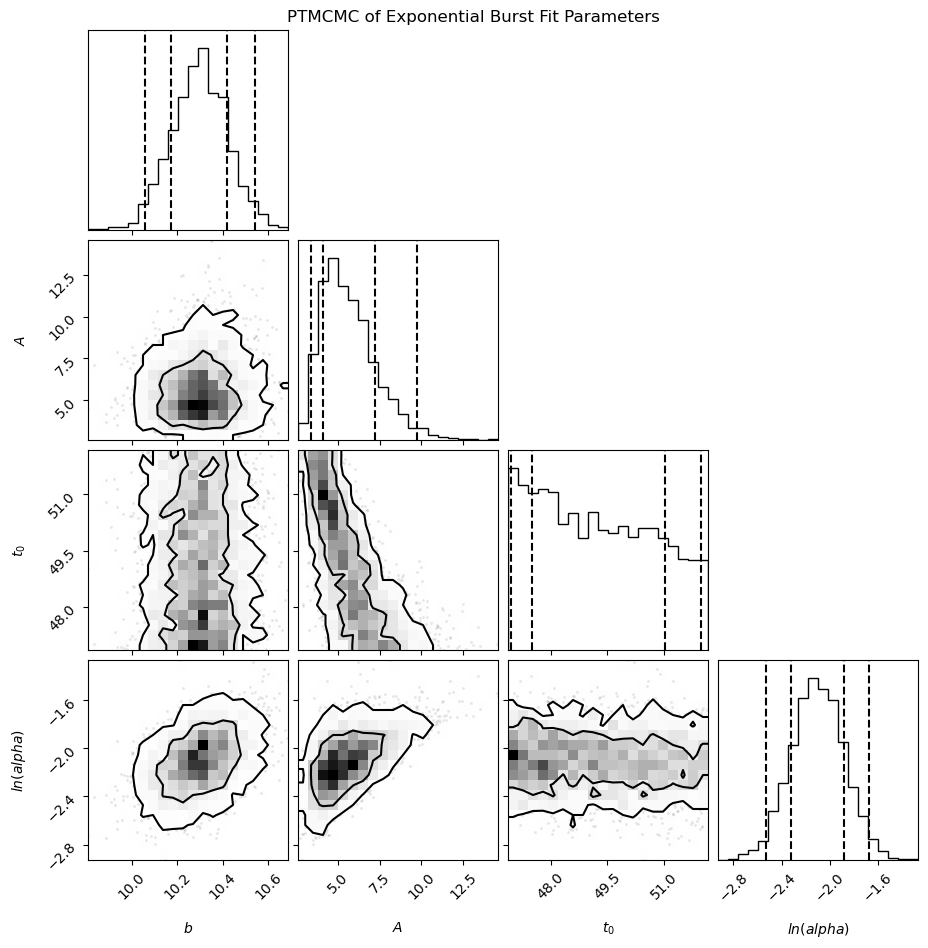

In [242]:
#Stealing this from Lecture 11
# ----------------------------------------------------------------------
#plotting corner plot
fig = corner.corner(thin_chain, 
                    quantiles=(0.025, 0.16, 0.84, 0.975), 
                    levels=(0.68,0.95), 
                    labels=('$b$','$A$','$t_0$','$ln(alpha)$'));
fig.suptitle("PTMCMC of Exponential Burst Fit Parameters");

SRT: Very nice work!!

### Part 6

In [243]:
#Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. 
# You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. 
# These are showing the posterior spread of model solutions that are consistent with the data.

#randomly sampling 100 samples from the processed chain (?)
nsamps = 100
#samps100 = np.random.choice()
samps100 = []
for i in range (0,nsamps):
    indices = np.random.choice(np.arange(burn_chain.shape[0]), #this is from your comments on hw3
                                   size=burn_chain.shape[0], 
                                   replace=True)
    samps100.append(burn_chain[indices])

In [244]:
print(samps100[0][0])

[10.40627606  5.33303061 50.36478651 -1.92774478]


In [245]:
print(len(samps100))

100


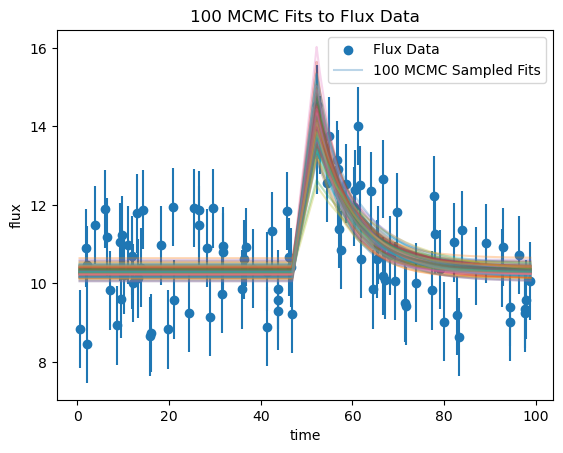

In [257]:
#plotting against original data
plt.scatter(t,flux, label='Recorded Flux Data') #original data
plt.errorbar(x=t,y=flux,yerr=sigma_fl, fmt='None')
plt.title('100 MCMC Fits to Flux Data')

#new fits
for i in range(len(samps100)):
    plt.plot(t,exp_burst_fit(theta=samps100[0][i],x=t),
              #color='red',
              alpha=0.3 #, label='Potential Fit Gleaned from MCMC')
    )

plt.xlabel('time')
plt.ylabel('flux')
plt.legend(['Flux Data', '100 MCMC Sampled Fits'])

SRT: Cool!

### Part 7

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

In [99]:
#new additional prior
ln_sigw_prior = scipy.stats.uniform(-2,4) #lower bound at -2, width of 4 = upper bound of 2

#building new model
def new_model(theta2, x):
    b,A,t0,sigw = theta2
    z=[]
    for t in x:
        zz = b + A*np.exp((-(t-t0)**2)/(2*sigw**2))
        z.append(zz)
    return z

In [115]:
#Building new log lieklihood
# compute the data log-likelihood given a model
def logLSigW(params, data=data, model=new_model):
    #"""Gaussian log-likelihood of the model at theta"""
    #separating data into columns
    x = data[:,0]
    y = data[:,1]
    sigma_y = data[:,2]
    #fitting model
    y_fit = new_model(params, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

Using UltraNest instead of dynesty!!

In [117]:
#using ultranest
import ultranest

For Gaussian Fit Model

In [128]:
#for these techniques (dynesty, ultranest), need to map the parameter space to the unitary values it assumes
def my_prior_transform(cube):
    params = cube.copy()        #mapping parameters to a unit hypercube in n dimensions for ease of use. 

    # transform location parameter: uniform prior in b
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform location parameter: uniform prior in A
    lo = 0
    hi = 100
    params[1] = cube[1] * (hi - lo) + lo

    # transform location parameter: uniform prior in t0
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo

    # transform amplitude parameter: uniform prior in lnSigW
    lo = -2
    hi = 2
    params[3] = (cube[3] * ((hi) - (lo)) + (lo))

    return params

In [129]:
#defining parameters
param_names = ['b', 'A', 't0','lnSigW'] #background, amplitude, initial time of peak, gaussian stdev

#running sampler
ultnestsamp = ultranest.ReactiveNestedSampler(param_names, logLSigW, my_prior_transform)

In [131]:
#looking at ultranest sampler results
result = ultnestsamp.run()
ultnestsamp.print_results()

[ultranest] Widening roots to 400 live points (have 400 already) ...


[ultranest] Explored until L=-2e+02  .78 [-152.0167..-152.0166]*| it/evals=8440/135558 eff=4.8143% N=400 
[ultranest] Likelihood function evaluations: 135560
[ultranest]   logZ = -168.4 +- 0.1539
[ultranest] Effective samples strategy satisfied (ESS = 2288.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy wants 398 minimum live points (dlogz from 0.12 to 0.55, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.

logZ = -168.441 +- 0.196
  single instance: logZ = -168.441 +- 0.189
  bootstrapped   : logZ = -168.448 +- 0.196
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 10.09 │ ▁▁ ▁▁▁▁▁▁▁▁▂▃▄▄▅▅▆▇▇▆▇▆▅▄▄▄▃▂▁▁▁▁▁▁▁▁ │10.92     10.53 +- 0.10
    A                   : 1.51  │ ▁ ▁▁▁▁▁▁▁▂▂▃▄▅▆▇▇▇▆▆▅▄▃▂▁▁▁▁▁▁▁ ▁▁  ▁ │6.68      3.88 +- 0.54


Text(0.5, 0.98, 'Ultranest Sampling of Gaussian Fit to Data')

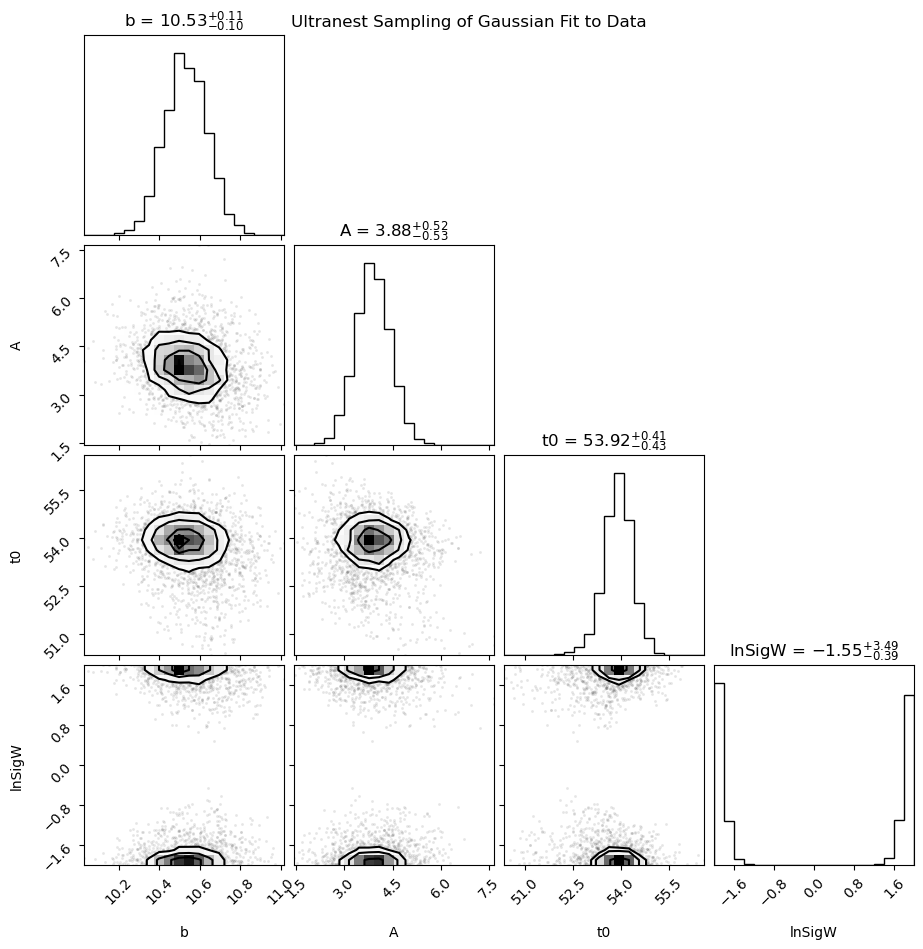

In [132]:
from ultranest.plot import cornerplot
cornerplot(result)
plt.suptitle('Ultranest Sampling of Gaussian Fit to Data')

SRT: Mostly fine, but a few small problems here, Ryan. Your prior on A is [0,100] instead of [0,50]. Also, I don't see that you've converted from log-sigma back to sigma for inclusion in the Gaussian profile model. -4 points.

For Original Burst Fit Model

In [133]:
#Defining new prior space

#for these techniques (dynesty, ultranest), need to map the parameter space to the unitary values it assumes
def my_prior_transform_burst(cube):
    params = cube.copy()        #mapping parameters to a unit hypercube in n dimensions for ease of use. 

    # transform location parameter: uniform prior in b
    lo = 0
    hi = 50
    params[0] = cube[0] * (hi - lo) + lo

    # transform location parameter: uniform prior in A
    lo = 0
    hi = 100
    params[1] = cube[1] * (hi - lo) + lo

    # transform location parameter: uniform prior in t0
    lo = 0
    hi = 100
    params[2] = cube[2] * (hi - lo) + lo

    # transform amplitude parameter: uniform prior in lnalpha
    lo = -5
    hi = 5
    params[3] = (cube[3] * ((hi) - (lo)) + (lo))

    return params

In [134]:
#defining parameters
param_names_burst = ['b', 'A', 't0','lnalpha'] #background, amplitude, initial time of peak, gaussian stdev

#running sampler
ultnestsamp_burst = ultranest.ReactiveNestedSampler(param_names_burst, logL, my_prior_transform_burst)

In [135]:
#looking at ultranest sampler results
result_burst = ultnestsamp_burst.run()
ultnestsamp_burst.print_results()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .65 [-140.7093..-140.7093]*| it/evals=7979/109742 eff=7.2973% N=400    0 
[ultranest] Likelihood function evaluations: 109755
[ultranest]   logZ = -156 +- 0.1006
[ultranest] Effective samples strategy satisfied (ESS = 1893.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.19 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.

logZ = -156.032 +- 0.232
  single instance: logZ = -156.032 +- 0.186
  bootstrapped   : logZ = -155.998 +- 0.232
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    b                   : 9.81  │ ▁▁▁▁▁▁▁▁▂▂▂▃▃▄▅▅▆▆▇▆▇▆▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁ │10.76     10.29 +- 0.13
    A                   : 1.6   │ ▁▁▁▄▆▇▇▇▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁  ▁ ▁ ▁ │18.2      5.7 +- 1.7
    t0                  : 46.

Text(0.5, 0.98, 'Ultranest Sampling of Exponential Burst Fit to Data')

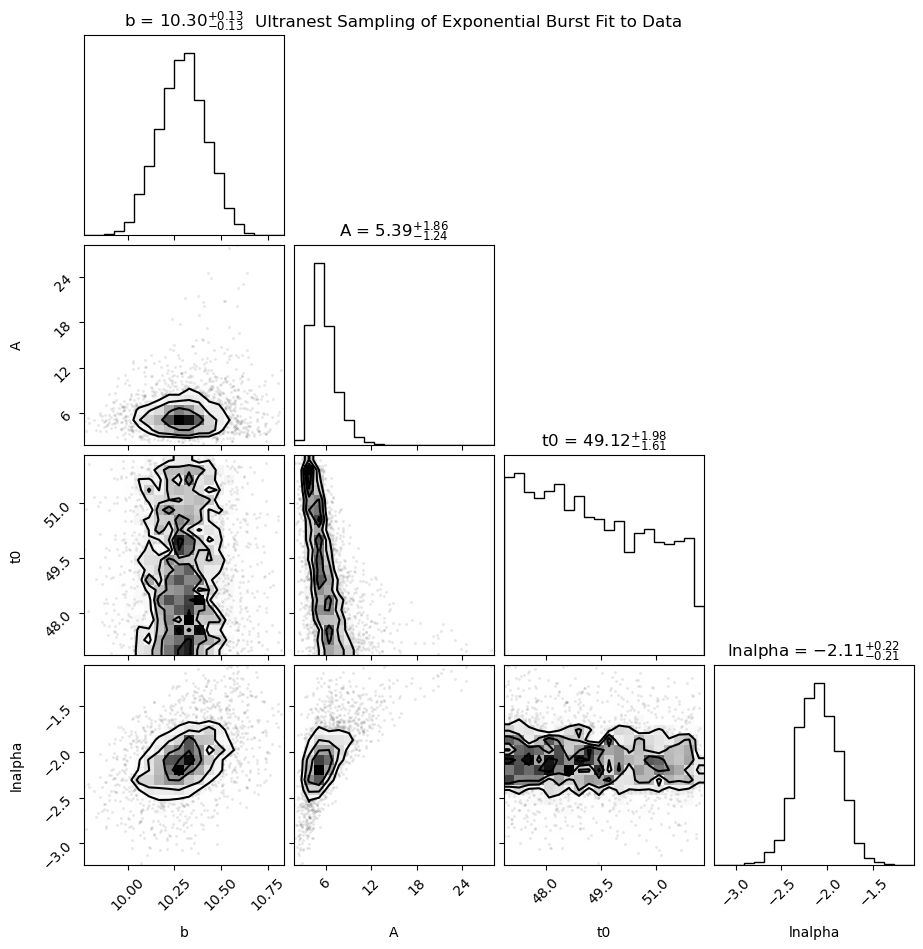

In [136]:
#plotting burst fit model
cornerplot(result_burst)
plt.suptitle('Ultranest Sampling of Exponential Burst Fit to Data')

Now to compute Bayes Factors and Evidences for the Models

In [254]:
#computing evidences
print(result.keys())

dict_keys(['niter', 'logz', 'logzerr', 'logz_bs', 'logz_single', 'logzerr_tail', 'logzerr_bs', 'ess', 'H', 'Herr', 'posterior', 'weighted_samples', 'samples', 'maximum_likelihood', 'ncall', 'paramnames', 'logzerr_single', 'insertion_order_MWW_test'])


In [258]:
#computing bayes factors
#this code was pulled directly from the documentation on UltraNest, located at:
#   https://johannesbuchner.github.io/UltraNest/example-sine-modelcomparison.html

#gaussian vs burst fit Bayes Factor
K = np.exp(result['logz'] - result_burst['logz']) #the logz is the log evidence gathered by ultranest. ultranest stores it in its dictionary of outputs under this key
print("K = %f" % K)
print("The Gaussian model is %f times more probable than the Exponential Burst model" % K)
print("assuming the models are equally probable a priori.")


#burst vs gaussian fit Bayes Factor
Q = np.exp(result_burst['logz'] - result['logz']) 
print("Q = %.2f" % Q)
print("The Exponential Burst model is %.2f times more probable than the Gaussian model" % Q)
print("assuming the models are equally probable a priori.")


K = 0.000004
The Gaussian model is 0.000004 times more probable than the Exponential Burst model
assuming the models are equally probable a priori.
Q = 245121.97
The Exponential Burst model is 245121.97 times more probable than the Gaussian model
assuming the models are equally probable a priori.


<font color='lime'> From this, it seems that the exponential burst model is significantly better at matching the data than the Gaussian model is. It is important to note this is only a comparison between the models, and not an overall measure of success as compared with any arbitrary model. </font>

SRT: Error carried through for the amplitude prior. Your overall conclusion is correct, but the number is quite a bit off. I think this is because of the lack of log-sigma conversion to sigma in the Gaussian-profile model. But your procedures are all otherwise correct.